### Part 1: Testing and Visualization of the PVWatts API and Results 

In [2]:
import altair as alt
import json
import pandas as pd 
import os
import requests
from dotenv import load_dotenv

load_dotenv()

API_KEY = os.environ.get("API_KEY")
FORMAT = "json"
PVWATTS_URL = f"https://developer.nrel.gov/api/pvwatts/v8.{FORMAT}"
print(f"Format of the output data: {FORMAT}")

Format of the output data: json


In [15]:
%%time

payload = {
    "api_key": API_KEY,
    "system_capacity": 67.5, # 67.5 KWp at Tochigi site 
    "module_type": 1, # 1 for modern AR coated modules 
    "losses": 0, # Losses in percent 
    "array_type": 1, # Fixed roof mounted 
    "tilt": 10, # Tilt angle for SG 
    "azimuth": 180, # Using default value for northern hemisphere
    "lat": 36.949449, #Tochigi Site 
    "lon": 140.004978, #Tochigi Site
    "timeframe": "monthly"
}

response = requests.get(PVWATTS_URL, params=payload)

CPU times: user 39.8 ms, sys: 75 µs, total: 39.9 ms
Wall time: 1.71 s


In [16]:
pvwatts_ac = response.json()["outputs"]["ac_monthly"]
jp_ac = pd.read_csv("../data/Japan/SolarEdge Japan Tochigi Power.csv")["Energy (Wh)"]

In [17]:
jp_ac/1000

0     5222.437
1     6803.546
2     8208.753
3     9157.155
4     7635.177
5     7789.442
6     7713.253
7     7008.331
8     2087.979
9     4056.173
10    5382.303
11    4457.103
12    5397.159
13    6630.801
14    7524.132
15    8289.782
16    8888.554
17    7664.958
18    7984.917
19    5692.243
20    6141.930
21    5888.937
22    5267.807
23    4446.403
Name: Energy (Wh), dtype: float64

In [20]:
source = pd.DataFrame({
    # "Month": pd.date_range(start="01/01/2021", freq="M", periods=12*2, inclusive="both"),
    "PVWatts AC Power": pvwatts_ac*2,
    "Japan Tochigi Site": jp_ac/1000
})

<Axes: >

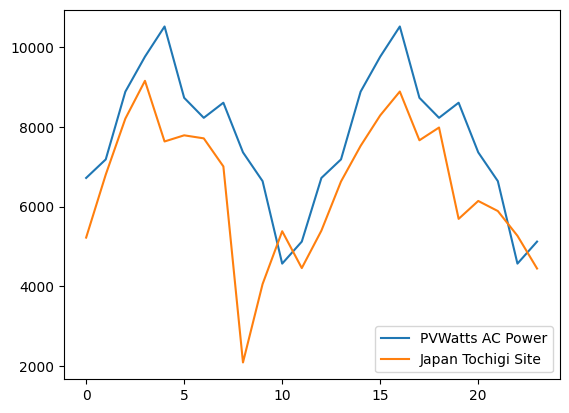

In [21]:
source.plot()

In [13]:
alt.data_transformers.disable_max_rows()


alt.Chart(source).mark_line().encode(
    x="Month",
    y="AC Power"
).properties(width=1000, height=600)

ValueError: AC Power encoding field is specified without a type; the type cannot be inferred because it does not match any column in the data.

alt.Chart(...)

In [12]:
# Adjust the year by year degradation rates to be 0.5% 
import numpy as np 
degradation_factor = np.linspace(start=0.97, stop=(0.97*0.995**25), num=(12*25))

In [13]:
source["Realistic AC Power"] = source["AC Power"] * degradation_factor

In [14]:
source

,Month,AC Power,Realistic AC Power
0,2023-01-31,13595.867926,13187.991889
1,2023-02-28,12824.486876,12434.852099
2,2023-03-31,13893.978541,13466.541549
3,2023-04-30,12297.793103,11914.762539
4,2023-05-31,11467.060290,11105.522462
...,...,...,...
295,2047-08-31,12178.294090,10440.232498
296,2047-09-30,12558.575531,10761.442371
297,2047-10-31,12202.100453,10451.316545
298,2047-11-30,10633.867516,9104.033934


In [17]:
data = source.melt("Month")
data

,Month,variable,value
0,2023-01-31,AC Power,13595.867926
1,2023-02-28,AC Power,12824.486876
2,2023-03-31,AC Power,13893.978541
3,2023-04-30,AC Power,12297.793103
4,2023-05-31,AC Power,11467.060290
...,...,...,...
595,2047-08-31,Realistic AC Power,10440.232498
596,2047-09-30,Realistic AC Power,10761.442371
597,2047-10-31,Realistic AC Power,10451.316545
598,2047-11-30,Realistic AC Power,9104.033934


In [18]:
alt.data_transformers.disable_max_rows()

alt.Chart(data).mark_line().encode(
    x='Month',
    y='value',
    color='variable'
).interactive(
).properties(width=1000, height=600)

alt.Chart(...)

### Part 2: Using Different Combinations of System Capacity, Module Type, Array Type and Tilt Angle to Get PVWatts Results

In [19]:
# Creating the configuration to generate more data 

payload = {
    "api_key": API_KEY,
    "system_capacity": 100, # 100KW 
    "module_type": 1, # 1 for modern AR coated modules 
    "losses": 0, # Losses in percent 
    "array_type": 1, # Fixed roof mounted 
    "tilt": 10, # Tilt angle for SG 
    "azimuth": 180, # Using default value for northern hemisphere
    "lat": 1.3521,
    "lon": 103.8198,
    "timeframe": "monthly"
}

capacity_list = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90]
module_type_list = [0, 1, 2]
array_type_list = [0, 1]
tilt_list = [5, 10, 15, 30]

In [20]:
from itertools import product
payload_list = list(product(capacity_list, module_type_list, array_type_list, tilt_list))
print(f"There are {len(payload_list)} combinations of payload.")

There are 240 combinations of payload.


In [21]:
combi_count = 1

for combi in payload_list:
    payload["system_capacity"] = combi[0]
    payload["module_type"] = combi[1]
    payload["array_type"] = combi[2]
    payload["tilt"] = combi[3]
    
    print(f"Starting combi {combi_count} out of {len(payload_list)}")
    combi_count += 1
    
    print(f"Getting data using system_capacity {combi[0]}, module_type {combi[1]}, array_type {combi[2]} and tilt {combi[3]}")
    response = requests.get(PVWATTS_URL, params=payload)
    print(f"Saving json data for system_capacity {combi[0]}, module_type {combi[1]}, array_type {combi[2]} and tilt {combi[3]}")
    with open(f"data/pvwatts/raw_monthly/system_capacity{combi[0]}_module_type{combi[1]}_array_type{combi[2]}_tilt{combi[3]}.json", "w") as outfile:
        json.dump(response.json(), outfile)
    print("### Json data saved! ###")
    

Starting combi 1 out of 240
Getting data using system_capacity 1, module_type 0, array_type 0 and tilt 5
Saving json data for system_capacity 1, module_type 0, array_type 0 and tilt 5
### Json data saved! ###
Starting combi 2 out of 240
Getting data using system_capacity 1, module_type 0, array_type 0 and tilt 10
Saving json data for system_capacity 1, module_type 0, array_type 0 and tilt 10
### Json data saved! ###
Starting combi 3 out of 240
Getting data using system_capacity 1, module_type 0, array_type 0 and tilt 15
Saving json data for system_capacity 1, module_type 0, array_type 0 and tilt 15
### Json data saved! ###
Starting combi 4 out of 240
Getting data using system_capacity 1, module_type 0, array_type 0 and tilt 30
Saving json data for system_capacity 1, module_type 0, array_type 0 and tilt 30
### Json data saved! ###
Starting combi 5 out of 240
Getting data using system_capacity 1, module_type 0, array_type 1 and tilt 5
Saving json data for system_capacity 1, module_type 0

In [23]:
from pathlib import Path

DATA_DIR = "./data/pvwatts/raw_monthly/"
DATA_PATH = Path(DATA_DIR)

counter = 0
for file in DATA_PATH.iterdir():
    if file.is_file():
        counter += 1

print(f"Total Files: {counter}")

Total Files: 240
